<a href="https://colab.research.google.com/github/Sompote/particle_VIT/blob/main/classification_with_vision_transformer_26AUG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Setup

In [5]:
!pip install -U tensorflow-addons

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [2]:
#convolution ANN
import tensorflow as tf
import cv2
import numpy as np
import os
import os, re, glob
import pandas as pd
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/gradation/picture/select/'
df_test = pd.read_excel('/content/drive/MyDrive/gradation/picture/select/test.xlsx')
test=np.transpose(np.array(df_test))
test=test[1:,]

files = glob.glob(os.path.join(path, '*.jpeg'))
files.sort(key=lambda x:[int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)]) #sort file name
# Read the training images using OpenCV and store them in a list
train_images = []
for files_read in files:
    img = cv2.imread(files_read)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Is optional but i recommend (float convertion and convert img to tensor image)
    #rgb_tensor = tf.convert_to_tensor(rgb, dtype=tf.float32)

    #Add dims to rgb_tensor
    #gb_tensor = tf.expand_dims(rgb_tensor , 0)
    train_images.append(rgb)

# Convert the training images to a numpy array and normalize the pixel values
train_images = np.array(train_images) / 255.0

# Define the training labels
train_labels = np.array([0, 1, 2, 3] * (len(train_images)//4))
#train=test*(len(train_images)//4)
# Split the data into training and validation sets
split_index = int(0.9 * len(train_images))
x_train, x_test = train_images[:split_index], train_images[split_index:]
y_train, y_test = test[:split_index], test[split_index:]
num_classes = 100
input_shape = (x_train.shape[1], x_train.shape[2], 3)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

sc_y=StandardScaler()
y_train=sc_y.fit_transform(y_train)


num_classes = 6


x_train shape: (9, 4032, 3024, 3) - y_train shape: (9, 6)
x_test shape: (1, 4032, 3024, 3) - y_test shape: (1, 6)


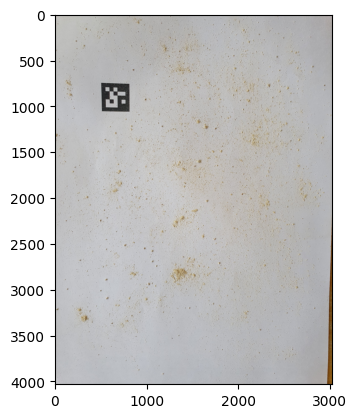

In [8]:
plt.imshow(x_train[1])

In [ ]:
train_images.shape

(10, 4032, 3024)

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")



169001437/169001437 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
y_train

array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 600  # We'll resize input images to this size
patch_size = 60  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
           # height_factor=0.2, width_factor=0.2
       # ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [5]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [6]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 600 X 600
Patch size: 16 X 16
Patches per image: 1369
Elements per patch: 768


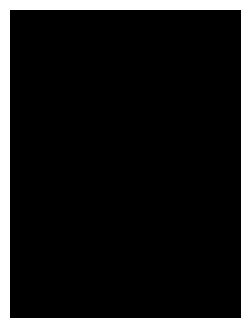

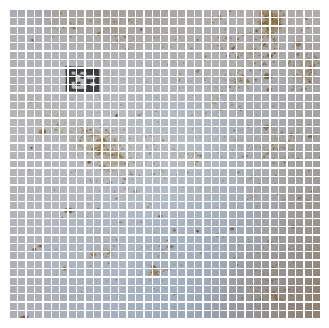

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [7]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [8]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(6)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [9]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,loss=keras.losses.mean_squared_error,
        metrics=[keras.metrics.mean_squared_error],
    )
    model.summary()

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

   # model.load_weights(checkpoint_filepath)
   # _, accuracy= model.evaluate(x_test, y_test)
   # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
   # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4032, 3024,  0           []                               
                                 3)]                                                              
                                                                                                  
 data_augmentation (Sequential)  (None, 600, 600, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 10800)  0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 100, 64)      697664      ['patches[0][0]']            

1/1 [==============================] - 24s 24s/step - loss: 6.5276 - mean_squared_error: 6.5276 - val_loss: 0.9981 - val_mean_squared_error: 0.9981
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 6.3577 - mean_squared_error: 6.3577

1/1 [==============================] - 3s 3s/step - loss: 6.3577 - mean_squared_error: 6.3577 - val_loss: 22.3261 - val_mean_squared_error: 22.3261
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 34.5275 - mean_squared_error: 34.5275

1/1 [==============================] - 3s 3s/step - loss: 34.5275 - mean_squared_error: 34.5275 - val_loss: 140.0692 - val_mean_squared_error: 140.0692
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 193.9373 - mean_squared_error: 193.9373

1/1 [==============================] - 4s 4s/step - loss: 193.9373 - mean_squared_error: 193.9373 - val_loss: 4.3231 - val_mean_squared_error: 4.3231
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 22.9552 - mean_squared_error: 22.9552

1/1 [==============================] - 5s 5s/step - loss: 22.9552 - mean_squared_error: 22.9552 - val_loss: 31.8245 - val_mean_squared_error: 31.8245
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 43.6014 - mean_squared_error: 43.6014

1/1 [==============================] - 3s 3s/step - loss: 43.6014 - mean_squared_error: 43.6014 - val_loss: 34.6308 - val_mean_squared_error: 34.6308
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 63.8568 - mean_squared_error: 63.8568

1/1 [==============================] - 3s 3s/step - loss: 63.8568 - mean_squared_error: 63.8568 - val_loss: 6.5043 - val_mean_squared_error: 6.5043
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 31.3436 - mean_squared_error: 31.3436

1/1 [==============================] - 4s 4s/step - loss: 31.3436 - mean_squared_error: 31.3436 - val_loss: 19.0413 - val_mean_squared_error: 19.0413
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 47.0338 - mean_squared_error: 47.0338

1/1 [==============================] - 10s 10s/step - loss: 47.0338 - mean_squared_error: 47.0338 - val_loss: 11.2112 - val_mean_squared_error: 11.2112
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 34.1212 - mean_squared_error: 34.1212

1/1 [==============================] - 5s 5s/step - loss: 34.1212 - mean_squared_error: 34.1212 - val_loss: 14.0055 - val_mean_squared_error: 14.0055
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 39.2910 - mean_squared_error: 39.2910

1/1 [==============================] - 6s 6s/step - loss: 39.2910 - mean_squared_error: 39.2910 - val_loss: 9.2281 - val_mean_squared_error: 9.2281
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 19.8809 - mean_squared_error: 19.8809

1/1 [==============================] - 10s 10s/step - loss: 19.8809 - mean_squared_error: 19.8809 - val_loss: 8.4452 - val_mean_squared_error: 8.4452
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 28.0859 - mean_squared_error: 28.0859

1/1 [==============================] - 3s 3s/step - loss: 28.0859 - mean_squared_error: 28.0859 - val_loss: 7.2080 - val_mean_squared_error: 7.2080
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 11.0336 - mean_squared_error: 11.0336

1/1 [==============================] - 5s 5s/step - loss: 11.0336 - mean_squared_error: 11.0336 - val_loss: 10.4591 - val_mean_squared_error: 10.4591
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 18.6236 - mean_squared_error: 18.6236

1/1 [==============================] - 3s 3s/step - loss: 18.6236 - mean_squared_error: 18.6236 - val_loss: 7.9417 - val_mean_squared_error: 7.9417
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 15.0339 - mean_squared_error: 15.0339

1/1 [==============================] - 3s 3s/step - loss: 15.0339 - mean_squared_error: 15.0339 - val_loss: 3.8749 - val_mean_squared_error: 3.8749
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 17.6401 - mean_squared_error: 17.6401

1/1 [==============================] - 3s 3s/step - loss: 17.6401 - mean_squared_error: 17.6401 - val_loss: 3.1083 - val_mean_squared_error: 3.1083
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 12.4889 - mean_squared_error: 12.4889

1/1 [==============================] - 5s 5s/step - loss: 12.4889 - mean_squared_error: 12.4889 - val_loss: 4.4901 - val_mean_squared_error: 4.4901
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 14.0264 - mean_squared_error: 14.0264

1/1 [==============================] - 3s 3s/step - loss: 14.0264 - mean_squared_error: 14.0264 - val_loss: 5.9206 - val_mean_squared_error: 5.9206
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 10.9856 - mean_squared_error: 10.9856

1/1 [==============================] - 4s 4s/step - loss: 10.9856 - mean_squared_error: 10.9856 - val_loss: 3.9050 - val_mean_squared_error: 3.9050
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 10.8241 - mean_squared_error: 10.8241

1/1 [==============================] - 3s 3s/step - loss: 10.8241 - mean_squared_error: 10.8241 - val_loss: 2.5855 - val_mean_squared_error: 2.5855
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 9.2340 - mean_squared_error: 9.2340

1/1 [==============================] - 5s 5s/step - loss: 9.2340 - mean_squared_error: 9.2340 - val_loss: 2.2921 - val_mean_squared_error: 2.2921
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 8.7030 - mean_squared_error: 8.7030

1/1 [==============================] - 3s 3s/step - loss: 8.7030 - mean_squared_error: 8.7030 - val_loss: 3.0237 - val_mean_squared_error: 3.0237
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 12.2872 - mean_squared_error: 12.2872

1/1 [==============================] - 3s 3s/step - loss: 12.2872 - mean_squared_error: 12.2872 - val_loss: 2.4193 - val_mean_squared_error: 2.4193
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 6.5197 - mean_squared_error: 6.5197

1/1 [==============================] - 4s 4s/step - loss: 6.5197 - mean_squared_error: 6.5197 - val_loss: 2.2507 - val_mean_squared_error: 2.2507
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 8.2341 - mean_squared_error: 8.2341

1/1 [==============================] - 5s 5s/step - loss: 8.2341 - mean_squared_error: 8.2341 - val_loss: 2.6978 - val_mean_squared_error: 2.6978
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 6.0415 - mean_squared_error: 6.0415

1/1 [==============================] - 3s 3s/step - loss: 6.0415 - mean_squared_error: 6.0415 - val_loss: 3.0482 - val_mean_squared_error: 3.0482
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 5.7581 - mean_squared_error: 5.7581

1/1 [==============================] - 3s 3s/step - loss: 5.7581 - mean_squared_error: 5.7581 - val_loss: 2.3876 - val_mean_squared_error: 2.3876
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 8.3044 - mean_squared_error: 8.3044

1/1 [==============================] - 4s 4s/step - loss: 8.3044 - mean_squared_error: 8.3044 - val_loss: 1.1338 - val_mean_squared_error: 1.1338
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 5.0073 - mean_squared_error: 5.0073

1/1 [==============================] - 4s 4s/step - loss: 5.0073 - mean_squared_error: 5.0073 - val_loss: 0.8188 - val_mean_squared_error: 0.8188
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 4.1039 - mean_squared_error: 4.1039

1/1 [==============================] - 3s 3s/step - loss: 4.1039 - mean_squared_error: 4.1039 - val_loss: 1.0727 - val_mean_squared_error: 1.0727
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 4.0365 - mean_squared_error: 4.0365

1/1 [==============================] - 3s 3s/step - loss: 4.0365 - mean_squared_error: 4.0365 - val_loss: 0.8936 - val_mean_squared_error: 0.8936
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 4.2252 - mean_squared_error: 4.2252

1/1 [==============================] - 5s 5s/step - loss: 4.2252 - mean_squared_error: 4.2252 - val_loss: 0.4724 - val_mean_squared_error: 0.4724
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 3.5332 - mean_squared_error: 3.5332

1/1 [==============================] - 6s 6s/step - loss: 3.5332 - mean_squared_error: 3.5332 - val_loss: 0.3055 - val_mean_squared_error: 0.3055
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 3.3192 - mean_squared_error: 3.3192

1/1 [==============================] - 6s 6s/step - loss: 3.3192 - mean_squared_error: 3.3192 - val_loss: 0.4182 - val_mean_squared_error: 0.4182
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 3.3963 - mean_squared_error: 3.3963

1/1 [==============================] - 5s 5s/step - loss: 3.3963 - mean_squared_error: 3.3963 - val_loss: 0.5229 - val_mean_squared_error: 0.5229
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 3.5404 - mean_squared_error: 3.5404

1/1 [==============================] - 6s 6s/step - loss: 3.5404 - mean_squared_error: 3.5404 - val_loss: 0.7404 - val_mean_squared_error: 0.7404
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 3.4243 - mean_squared_error: 3.4243

1/1 [==============================] - 4s 4s/step - loss: 3.4243 - mean_squared_error: 3.4243 - val_loss: 0.9712 - val_mean_squared_error: 0.9712
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 3.5727 - mean_squared_error: 3.5727

1/1 [==============================] - 3s 3s/step - loss: 3.5727 - mean_squared_error: 3.5727 - val_loss: 1.1988 - val_mean_squared_error: 1.1988
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 3.1330 - mean_squared_error: 3.1330

1/1 [==============================] - 3s 3s/step - loss: 3.1330 - mean_squared_error: 3.1330 - val_loss: 1.2192 - val_mean_squared_error: 1.2192
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 2.9636 - mean_squared_error: 2.9636

1/1 [==============================] - 5s 5s/step - loss: 2.9636 - mean_squared_error: 2.9636 - val_loss: 1.1349 - val_mean_squared_error: 1.1349
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 2.9579 - mean_squared_error: 2.9579

1/1 [==============================] - 4s 4s/step - loss: 2.9579 - mean_squared_error: 2.9579 - val_loss: 0.9843 - val_mean_squared_error: 0.9843
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 2.6937 - mean_squared_error: 2.6937

1/1 [==============================] - 3s 3s/step - loss: 2.6937 - mean_squared_error: 2.6937 - val_loss: 0.7731 - val_mean_squared_error: 0.7731
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 1.5087 - mean_squared_error: 1.5087

1/1 [==============================] - 3s 3s/step - loss: 1.5087 - mean_squared_error: 1.5087 - val_loss: 0.5609 - val_mean_squared_error: 0.5609
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 1.8375 - mean_squared_error: 1.8375

1/1 [==============================] - 5s 5s/step - loss: 1.8375 - mean_squared_error: 1.8375 - val_loss: 0.4018 - val_mean_squared_error: 0.4018
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 2.0232 - mean_squared_error: 2.0232

1/1 [==============================] - 4s 4s/step - loss: 2.0232 - mean_squared_error: 2.0232 - val_loss: 0.2796 - val_mean_squared_error: 0.2796
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 1.5278 - mean_squared_error: 1.5278

1/1 [==============================] - 3s 3s/step - loss: 1.5278 - mean_squared_error: 1.5278 - val_loss: 0.2872 - val_mean_squared_error: 0.2872
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 1.6932 - mean_squared_error: 1.6932

1/1 [==============================] - 3s 3s/step - loss: 1.6932 - mean_squared_error: 1.6932 - val_loss: 0.3818 - val_mean_squared_error: 0.3818
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 2.2820 - mean_squared_error: 2.2820

1/1 [==============================] - 5s 5s/step - loss: 2.2820 - mean_squared_error: 2.2820 - val_loss: 0.3439 - val_mean_squared_error: 0.3439
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 2.2231 - mean_squared_error: 2.2231

1/1 [==============================] - 4s 4s/step - loss: 2.2231 - mean_squared_error: 2.2231 - val_loss: 0.3577 - val_mean_squared_error: 0.3577
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 1.1531 - mean_squared_error: 1.1531

1/1 [==============================] - 3s 3s/step - loss: 1.1531 - mean_squared_error: 1.1531 - val_loss: 0.3852 - val_mean_squared_error: 0.3852
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 2.0505 - mean_squared_error: 2.0505

1/1 [==============================] - 3s 3s/step - loss: 2.0505 - mean_squared_error: 2.0505 - val_loss: 0.4348 - val_mean_squared_error: 0.4348
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 1.7819 - mean_squared_error: 1.7819

1/1 [==============================] - 5s 5s/step - loss: 1.7819 - mean_squared_error: 1.7819 - val_loss: 0.5006 - val_mean_squared_error: 0.5006
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 1.8190 - mean_squared_error: 1.8190

1/1 [==============================] - 4s 4s/step - loss: 1.8190 - mean_squared_error: 1.8190 - val_loss: 0.5104 - val_mean_squared_error: 0.5104
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 1.6183 - mean_squared_error: 1.6183

1/1 [==============================] - 3s 3s/step - loss: 1.6183 - mean_squared_error: 1.6183 - val_loss: 0.4619 - val_mean_squared_error: 0.4619
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 1.6656 - mean_squared_error: 1.6656

1/1 [==============================] - 3s 3s/step - loss: 1.6656 - mean_squared_error: 1.6656 - val_loss: 0.3513 - val_mean_squared_error: 0.3513
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 1.4629 - mean_squared_error: 1.4629

1/1 [==============================] - 6s 6s/step - loss: 1.4629 - mean_squared_error: 1.4629 - val_loss: 0.2946 - val_mean_squared_error: 0.2946
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 1.5016 - mean_squared_error: 1.5016

1/1 [==============================] - 6s 6s/step - loss: 1.5016 - mean_squared_error: 1.5016 - val_loss: 0.2409 - val_mean_squared_error: 0.2409
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 1.2497 - mean_squared_error: 1.2497

1/1 [==============================] - 5s 5s/step - loss: 1.2497 - mean_squared_error: 1.2497 - val_loss: 0.2224 - val_mean_squared_error: 0.2224
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 1.5907 - mean_squared_error: 1.5907

1/1 [==============================] - 4s 4s/step - loss: 1.5907 - mean_squared_error: 1.5907 - val_loss: 0.3084 - val_mean_squared_error: 0.3084
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 1.5062 - mean_squared_error: 1.5062

1/1 [==============================] - 5s 5s/step - loss: 1.5062 - mean_squared_error: 1.5062 - val_loss: 0.4241 - val_mean_squared_error: 0.4241
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 1.1229 - mean_squared_error: 1.1229

1/1 [==============================] - 3s 3s/step - loss: 1.1229 - mean_squared_error: 1.1229 - val_loss: 0.5366 - val_mean_squared_error: 0.5366
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 1.4045 - mean_squared_error: 1.4045

1/1 [==============================] - 3s 3s/step - loss: 1.4045 - mean_squared_error: 1.4045 - val_loss: 0.6024 - val_mean_squared_error: 0.6024
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 1.1876 - mean_squared_error: 1.1876

1/1 [==============================] - 5s 5s/step - loss: 1.1876 - mean_squared_error: 1.1876 - val_loss: 0.5675 - val_mean_squared_error: 0.5675
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 1.2096 - mean_squared_error: 1.2096

1/1 [==============================] - 6s 6s/step - loss: 1.2096 - mean_squared_error: 1.2096 - val_loss: 0.4848 - val_mean_squared_error: 0.4848
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 1.3420 - mean_squared_error: 1.3420

1/1 [==============================] - 5s 5s/step - loss: 1.3420 - mean_squared_error: 1.3420 - val_loss: 0.4153 - val_mean_squared_error: 0.4153
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 1.2717 - mean_squared_error: 1.2717

1/1 [==============================] - 3s 3s/step - loss: 1.2717 - mean_squared_error: 1.2717 - val_loss: 0.3801 - val_mean_squared_error: 0.3801
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 1.0773 - mean_squared_error: 1.0773

1/1 [==============================] - 5s 5s/step - loss: 1.0773 - mean_squared_error: 1.0773 - val_loss: 0.3619 - val_mean_squared_error: 0.3619
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.9367 - mean_squared_error: 0.9367

1/1 [==============================] - 4s 4s/step - loss: 0.9367 - mean_squared_error: 0.9367 - val_loss: 0.3533 - val_mean_squared_error: 0.3533
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 1.3233 - mean_squared_error: 1.3233

1/1 [==============================] - 3s 3s/step - loss: 1.3233 - mean_squared_error: 1.3233 - val_loss: 0.3570 - val_mean_squared_error: 0.3570
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 1.0023 - mean_squared_error: 1.0023

1/1 [==============================] - 3s 3s/step - loss: 1.0023 - mean_squared_error: 1.0023 - val_loss: 0.3794 - val_mean_squared_error: 0.3794
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 1.1678 - mean_squared_error: 1.1678

1/1 [==============================] - 5s 5s/step - loss: 1.1678 - mean_squared_error: 1.1678 - val_loss: 0.4260 - val_mean_squared_error: 0.4260
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 1.0303 - mean_squared_error: 1.0303

1/1 [==============================] - 4s 4s/step - loss: 1.0303 - mean_squared_error: 1.0303 - val_loss: 0.4707 - val_mean_squared_error: 0.4707
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 1.4026 - mean_squared_error: 1.4026

1/1 [==============================] - 3s 3s/step - loss: 1.4026 - mean_squared_error: 1.4026 - val_loss: 0.4843 - val_mean_squared_error: 0.4843
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.9632 - mean_squared_error: 0.9632

1/1 [==============================] - 3s 3s/step - loss: 0.9632 - mean_squared_error: 0.9632 - val_loss: 0.4910 - val_mean_squared_error: 0.4910
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 1.2117 - mean_squared_error: 1.2117

1/1 [==============================] - 5s 5s/step - loss: 1.2117 - mean_squared_error: 1.2117 - val_loss: 0.4664 - val_mean_squared_error: 0.4664
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.9569 - mean_squared_error: 0.9569

1/1 [==============================] - 4s 4s/step - loss: 0.9569 - mean_squared_error: 0.9569 - val_loss: 0.4398 - val_mean_squared_error: 0.4398
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 1.3217 - mean_squared_error: 1.3217

1/1 [==============================] - 4s 4s/step - loss: 1.3217 - mean_squared_error: 1.3217 - val_loss: 0.4123 - val_mean_squared_error: 0.4123
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 1.0627 - mean_squared_error: 1.0627

1/1 [==============================] - 5s 5s/step - loss: 1.0627 - mean_squared_error: 1.0627 - val_loss: 0.3885 - val_mean_squared_error: 0.3885
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.9348 - mean_squared_error: 0.9348

1/1 [==============================] - 6s 6s/step - loss: 0.9348 - mean_squared_error: 0.9348 - val_loss: 0.3692 - val_mean_squared_error: 0.3692
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 1.2092 - mean_squared_error: 1.2092

1/1 [==============================] - 4s 4s/step - loss: 1.2092 - mean_squared_error: 1.2092 - val_loss: 0.3810 - val_mean_squared_error: 0.3810
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 1.0878 - mean_squared_error: 1.0878

1/1 [==============================] - 3s 3s/step - loss: 1.0878 - mean_squared_error: 1.0878 - val_loss: 0.4127 - val_mean_squared_error: 0.4127
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.9503 - mean_squared_error: 0.9503

1/1 [==============================] - 3s 3s/step - loss: 0.9503 - mean_squared_error: 0.9503 - val_loss: 0.4288 - val_mean_squared_error: 0.4288
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.9256 - mean_squared_error: 0.9256

1/1 [==============================] - 5s 5s/step - loss: 0.9256 - mean_squared_error: 0.9256 - val_loss: 0.4352 - val_mean_squared_error: 0.4352
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.9942 - mean_squared_error: 0.9942

1/1 [==============================] - 4s 4s/step - loss: 0.9942 - mean_squared_error: 0.9942 - val_loss: 0.4457 - val_mean_squared_error: 0.4457
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.9109 - mean_squared_error: 0.9109

1/1 [==============================] - 3s 3s/step - loss: 0.9109 - mean_squared_error: 0.9109 - val_loss: 0.4316 - val_mean_squared_error: 0.4316
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.9157 - mean_squared_error: 0.9157

1/1 [==============================] - 5s 5s/step - loss: 0.9157 - mean_squared_error: 0.9157 - val_loss: 0.4031 - val_mean_squared_error: 0.4031
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 1.0388 - mean_squared_error: 1.0388

1/1 [==============================] - 8s 8s/step - loss: 1.0388 - mean_squared_error: 1.0388 - val_loss: 0.3912 - val_mean_squared_error: 0.3912
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.8523 - mean_squared_error: 0.8523

1/1 [==============================] - 4s 4s/step - loss: 0.8523 - mean_squared_error: 0.8523 - val_loss: 0.3510 - val_mean_squared_error: 0.3510
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 1.1015 - mean_squared_error: 1.1015

1/1 [==============================] - 4s 4s/step - loss: 1.1015 - mean_squared_error: 1.1015 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.8355 - mean_squared_error: 0.8355

1/1 [==============================] - 6s 6s/step - loss: 0.8355 - mean_squared_error: 0.8355 - val_loss: 0.3443 - val_mean_squared_error: 0.3443
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 1.0303 - mean_squared_error: 1.0303

1/1 [==============================] - 6s 6s/step - loss: 1.0303 - mean_squared_error: 1.0303 - val_loss: 0.3813 - val_mean_squared_error: 0.3813
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.8911 - mean_squared_error: 0.8911

1/1 [==============================] - 3s 3s/step - loss: 0.8911 - mean_squared_error: 0.8911 - val_loss: 0.3818 - val_mean_squared_error: 0.3818
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.9192 - mean_squared_error: 0.9192

1/1 [==============================] - 4s 4s/step - loss: 0.9192 - mean_squared_error: 0.9192 - val_loss: 0.3674 - val_mean_squared_error: 0.3674
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 1.0093 - mean_squared_error: 1.0093

1/1 [==============================] - 5s 5s/step - loss: 1.0093 - mean_squared_error: 1.0093 - val_loss: 0.3777 - val_mean_squared_error: 0.3777
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.9386 - mean_squared_error: 0.9386

1/1 [==============================] - 3s 3s/step - loss: 0.9386 - mean_squared_error: 0.9386 - val_loss: 0.3890 - val_mean_squared_error: 0.3890
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.9678 - mean_squared_error: 0.9678

1/1 [==============================] - 3s 3s/step - loss: 0.9678 - mean_squared_error: 0.9678 - val_loss: 0.4131 - val_mean_squared_error: 0.4131
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.9722 - mean_squared_error: 0.9722

1/1 [==============================] - 4s 4s/step - loss: 0.9722 - mean_squared_error: 0.9722 - val_loss: 0.4059 - val_mean_squared_error: 0.4059
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.9613 - mean_squared_error: 0.9613

1/1 [==============================] - 5s 5s/step - loss: 0.9613 - mean_squared_error: 0.9613 - val_loss: 0.4046 - val_mean_squared_error: 0.4046
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.8971 - mean_squared_error: 0.8971

1/1 [==============================] - 5s 5s/step - loss: 0.8971 - mean_squared_error: 0.8971 - val_loss: 0.4012 - val_mean_squared_error: 0.4012


NotFoundError: ignored

In [10]:
history = run_experiment(vit_classifier)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4032, 3024,  0           []                               
                                 3)]                                                              
                                                                                                  
 data_augmentation (Sequential)  (None, 600, 600, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 10800)  0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 100, 64)      697664      ['patches[0][0]']            

1/1 [==============================] - 25s 25s/step - loss: 0.9855 - mean_squared_error: 0.9855 - val_loss: 0.3575 - val_mean_squared_error: 0.3575
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.0745 - mean_squared_error: 1.0745

1/1 [==============================] - 4s 4s/step - loss: 1.0745 - mean_squared_error: 1.0745 - val_loss: 0.5416 - val_mean_squared_error: 0.5416
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 1.2998 - mean_squared_error: 1.2998

1/1 [==============================] - 5s 5s/step - loss: 1.2998 - mean_squared_error: 1.2998 - val_loss: 0.4028 - val_mean_squared_error: 0.4028
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.4013 - mean_squared_error: 1.4013

1/1 [==============================] - 5s 5s/step - loss: 1.4013 - mean_squared_error: 1.4013 - val_loss: 1.0170 - val_mean_squared_error: 1.0170
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 2.0376 - mean_squared_error: 2.0376

1/1 [==============================] - 3s 3s/step - loss: 2.0376 - mean_squared_error: 2.0376 - val_loss: 0.6705 - val_mean_squared_error: 0.6705
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 1.6996 - mean_squared_error: 1.6996

1/1 [==============================] - 3s 3s/step - loss: 1.6996 - mean_squared_error: 1.6996 - val_loss: 0.6220 - val_mean_squared_error: 0.6220
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 2.6961 - mean_squared_error: 2.6961

1/1 [==============================] - 4s 4s/step - loss: 2.6961 - mean_squared_error: 2.6961 - val_loss: 0.3777 - val_mean_squared_error: 0.3777
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 1.6892 - mean_squared_error: 1.6892

1/1 [==============================] - 6s 6s/step - loss: 1.6892 - mean_squared_error: 1.6892 - val_loss: 0.4201 - val_mean_squared_error: 0.4201
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 1.8301 - mean_squared_error: 1.8301

1/1 [==============================] - 6s 6s/step - loss: 1.8301 - mean_squared_error: 1.8301 - val_loss: 1.0501 - val_mean_squared_error: 1.0501
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 1.3321 - mean_squared_error: 1.3321

1/1 [==============================] - 7s 7s/step - loss: 1.3321 - mean_squared_error: 1.3321 - val_loss: 1.3415 - val_mean_squared_error: 1.3415
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 1.9388 - mean_squared_error: 1.9388

1/1 [==============================] - 6s 6s/step - loss: 1.9388 - mean_squared_error: 1.9388 - val_loss: 1.1292 - val_mean_squared_error: 1.1292
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 1.9603 - mean_squared_error: 1.9603

1/1 [==============================] - 3s 3s/step - loss: 1.9603 - mean_squared_error: 1.9603 - val_loss: 0.7508 - val_mean_squared_error: 0.7508
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 1.5573 - mean_squared_error: 1.5573

1/1 [==============================] - 3s 3s/step - loss: 1.5573 - mean_squared_error: 1.5573 - val_loss: 0.4513 - val_mean_squared_error: 0.4513
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 1.7527 - mean_squared_error: 1.7527

1/1 [==============================] - 4s 4s/step - loss: 1.7527 - mean_squared_error: 1.7527 - val_loss: 0.3867 - val_mean_squared_error: 0.3867
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 1.1537 - mean_squared_error: 1.1537

1/1 [==============================] - 4s 4s/step - loss: 1.1537 - mean_squared_error: 1.1537 - val_loss: 0.3579 - val_mean_squared_error: 0.3579
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 1.6134 - mean_squared_error: 1.6134

1/1 [==============================] - 3s 3s/step - loss: 1.6134 - mean_squared_error: 1.6134 - val_loss: 0.4876 - val_mean_squared_error: 0.4876
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 1.4453 - mean_squared_error: 1.4453

1/1 [==============================] - 3s 3s/step - loss: 1.4453 - mean_squared_error: 1.4453 - val_loss: 0.5296 - val_mean_squared_error: 0.5296
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 1.6402 - mean_squared_error: 1.6402

1/1 [==============================] - 4s 4s/step - loss: 1.6402 - mean_squared_error: 1.6402 - val_loss: 0.6479 - val_mean_squared_error: 0.6479
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 1.3508 - mean_squared_error: 1.3508

1/1 [==============================] - 4s 4s/step - loss: 1.3508 - mean_squared_error: 1.3508 - val_loss: 0.5966 - val_mean_squared_error: 0.5966
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 1.2861 - mean_squared_error: 1.2861

1/1 [==============================] - 3s 3s/step - loss: 1.2861 - mean_squared_error: 1.2861 - val_loss: 0.4774 - val_mean_squared_error: 0.4774
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 1.2533 - mean_squared_error: 1.2533

1/1 [==============================] - 3s 3s/step - loss: 1.2533 - mean_squared_error: 1.2533 - val_loss: 0.3994 - val_mean_squared_error: 0.3994
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 1.2275 - mean_squared_error: 1.2275

1/1 [==============================] - 5s 5s/step - loss: 1.2275 - mean_squared_error: 1.2275 - val_loss: 0.4940 - val_mean_squared_error: 0.4940
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 1.4319 - mean_squared_error: 1.4319

1/1 [==============================] - 4s 4s/step - loss: 1.4319 - mean_squared_error: 1.4319 - val_loss: 0.6219 - val_mean_squared_error: 0.6219
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 1.3891 - mean_squared_error: 1.3891

1/1 [==============================] - 3s 3s/step - loss: 1.3891 - mean_squared_error: 1.3891 - val_loss: 0.7179 - val_mean_squared_error: 0.7179
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 1.3738 - mean_squared_error: 1.3738

1/1 [==============================] - 4s 4s/step - loss: 1.3738 - mean_squared_error: 1.3738 - val_loss: 0.4429 - val_mean_squared_error: 0.4429
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 1.5189 - mean_squared_error: 1.5189

1/1 [==============================] - 5s 5s/step - loss: 1.5189 - mean_squared_error: 1.5189 - val_loss: 0.3223 - val_mean_squared_error: 0.3223
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 1.2119 - mean_squared_error: 1.2119

1/1 [==============================] - 4s 4s/step - loss: 1.2119 - mean_squared_error: 1.2119 - val_loss: 0.3230 - val_mean_squared_error: 0.3230
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 1.1753 - mean_squared_error: 1.1753

1/1 [==============================] - 3s 3s/step - loss: 1.1753 - mean_squared_error: 1.1753 - val_loss: 0.3468 - val_mean_squared_error: 0.3468
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 1.1639 - mean_squared_error: 1.1639

1/1 [==============================] - 4s 4s/step - loss: 1.1639 - mean_squared_error: 1.1639 - val_loss: 0.3472 - val_mean_squared_error: 0.3472
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 1.2870 - mean_squared_error: 1.2870

1/1 [==============================] - 5s 5s/step - loss: 1.2870 - mean_squared_error: 1.2870 - val_loss: 0.3401 - val_mean_squared_error: 0.3401
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 1.2207 - mean_squared_error: 1.2207

1/1 [==============================] - 3s 3s/step - loss: 1.2207 - mean_squared_error: 1.2207 - val_loss: 0.3183 - val_mean_squared_error: 0.3183
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 1.0364 - mean_squared_error: 1.0364

1/1 [==============================] - 5s 5s/step - loss: 1.0364 - mean_squared_error: 1.0364 - val_loss: 0.4306 - val_mean_squared_error: 0.4306
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 1.1176 - mean_squared_error: 1.1176

1/1 [==============================] - 6s 6s/step - loss: 1.1176 - mean_squared_error: 1.1176 - val_loss: 0.5140 - val_mean_squared_error: 0.5140
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 1.2915 - mean_squared_error: 1.2915

1/1 [==============================] - 6s 6s/step - loss: 1.2915 - mean_squared_error: 1.2915 - val_loss: 0.5060 - val_mean_squared_error: 0.5060
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 1.0634 - mean_squared_error: 1.0634

1/1 [==============================] - 4s 4s/step - loss: 1.0634 - mean_squared_error: 1.0634 - val_loss: 0.5097 - val_mean_squared_error: 0.5097
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 1.1704 - mean_squared_error: 1.1704

1/1 [==============================] - 5s 5s/step - loss: 1.1704 - mean_squared_error: 1.1704 - val_loss: 0.5415 - val_mean_squared_error: 0.5415
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.9678 - mean_squared_error: 0.9678

1/1 [==============================] - 6s 6s/step - loss: 0.9678 - mean_squared_error: 0.9678 - val_loss: 0.4819 - val_mean_squared_error: 0.4819
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.9357 - mean_squared_error: 0.9357

1/1 [==============================] - 3s 3s/step - loss: 0.9357 - mean_squared_error: 0.9357 - val_loss: 0.4585 - val_mean_squared_error: 0.4585
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.8345 - mean_squared_error: 0.8345

1/1 [==============================] - 3s 3s/step - loss: 0.8345 - mean_squared_error: 0.8345 - val_loss: 0.4277 - val_mean_squared_error: 0.4277
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.9860 - mean_squared_error: 0.9860

1/1 [==============================] - 3s 3s/step - loss: 0.9860 - mean_squared_error: 0.9860 - val_loss: 0.4023 - val_mean_squared_error: 0.4023
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 1.2645 - mean_squared_error: 1.2645

1/1 [==============================] - 6s 6s/step - loss: 1.2645 - mean_squared_error: 1.2645 - val_loss: 0.4216 - val_mean_squared_error: 0.4216
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.9716 - mean_squared_error: 0.9716

1/1 [==============================] - 3s 3s/step - loss: 0.9716 - mean_squared_error: 0.9716 - val_loss: 0.4535 - val_mean_squared_error: 0.4535
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 1.0625 - mean_squared_error: 1.0625

1/1 [==============================] - 4s 4s/step - loss: 1.0625 - mean_squared_error: 1.0625 - val_loss: 0.4697 - val_mean_squared_error: 0.4697
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 1.0085 - mean_squared_error: 1.0085

1/1 [==============================] - 4s 4s/step - loss: 1.0085 - mean_squared_error: 1.0085 - val_loss: 0.4603 - val_mean_squared_error: 0.4603
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.8891 - mean_squared_error: 0.8891

1/1 [==============================] - 5s 5s/step - loss: 0.8891 - mean_squared_error: 0.8891 - val_loss: 0.4323 - val_mean_squared_error: 0.4323
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.9609 - mean_squared_error: 0.9609

1/1 [==============================] - 3s 3s/step - loss: 0.9609 - mean_squared_error: 0.9609 - val_loss: 0.3972 - val_mean_squared_error: 0.3972
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 1.1000 - mean_squared_error: 1.1000

1/1 [==============================] - 4s 4s/step - loss: 1.1000 - mean_squared_error: 1.1000 - val_loss: 0.3566 - val_mean_squared_error: 0.3566
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.8115 - mean_squared_error: 0.8115

1/1 [==============================] - 5s 5s/step - loss: 0.8115 - mean_squared_error: 0.8115 - val_loss: 0.3112 - val_mean_squared_error: 0.3112
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.8283 - mean_squared_error: 0.8283

1/1 [==============================] - 4s 4s/step - loss: 0.8283 - mean_squared_error: 0.8283 - val_loss: 0.2774 - val_mean_squared_error: 0.2774
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 1.4868 - mean_squared_error: 1.4868

1/1 [==============================] - 3s 3s/step - loss: 1.4868 - mean_squared_error: 1.4868 - val_loss: 0.3126 - val_mean_squared_error: 0.3126
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.9788 - mean_squared_error: 0.9788

1/1 [==============================] - 3s 3s/step - loss: 0.9788 - mean_squared_error: 0.9788 - val_loss: 0.3425 - val_mean_squared_error: 0.3425
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.8698 - mean_squared_error: 0.8698

1/1 [==============================] - 5s 5s/step - loss: 0.8698 - mean_squared_error: 0.8698 - val_loss: 0.2639 - val_mean_squared_error: 0.2639
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.9421 - mean_squared_error: 0.9421

1/1 [==============================] - 4s 4s/step - loss: 0.9421 - mean_squared_error: 0.9421 - val_loss: 0.2612 - val_mean_squared_error: 0.2612
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 1.1738 - mean_squared_error: 1.1738

1/1 [==============================] - 4s 4s/step - loss: 1.1738 - mean_squared_error: 1.1738 - val_loss: 0.3463 - val_mean_squared_error: 0.3463
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.9247 - mean_squared_error: 0.9247

1/1 [==============================] - 4s 4s/step - loss: 0.9247 - mean_squared_error: 0.9247 - val_loss: 0.4067 - val_mean_squared_error: 0.4067
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.8664 - mean_squared_error: 0.8664

1/1 [==============================] - 6s 6s/step - loss: 0.8664 - mean_squared_error: 0.8664 - val_loss: 0.4357 - val_mean_squared_error: 0.4357
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.9345 - mean_squared_error: 0.9345

1/1 [==============================] - 6s 6s/step - loss: 0.9345 - mean_squared_error: 0.9345 - val_loss: 0.4681 - val_mean_squared_error: 0.4681
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.8543 - mean_squared_error: 0.8543

1/1 [==============================] - 3s 3s/step - loss: 0.8543 - mean_squared_error: 0.8543 - val_loss: 0.4916 - val_mean_squared_error: 0.4916
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.9357 - mean_squared_error: 0.9357

1/1 [==============================] - 3s 3s/step - loss: 0.9357 - mean_squared_error: 0.9357 - val_loss: 0.5229 - val_mean_squared_error: 0.5229
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.7960 - mean_squared_error: 0.7960

1/1 [==============================] - 5s 5s/step - loss: 0.7960 - mean_squared_error: 0.7960 - val_loss: 0.5751 - val_mean_squared_error: 0.5751
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.8874 - mean_squared_error: 0.8874

1/1 [==============================] - 4s 4s/step - loss: 0.8874 - mean_squared_error: 0.8874 - val_loss: 0.6302 - val_mean_squared_error: 0.6302
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 1.1749 - mean_squared_error: 1.1749

1/1 [==============================] - 5s 5s/step - loss: 1.1749 - mean_squared_error: 1.1749 - val_loss: 0.6269 - val_mean_squared_error: 0.6269
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.9829 - mean_squared_error: 0.9829

1/1 [==============================] - 5s 5s/step - loss: 0.9829 - mean_squared_error: 0.9829 - val_loss: 0.5680 - val_mean_squared_error: 0.5680
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.9144 - mean_squared_error: 0.9144

1/1 [==============================] - 6s 6s/step - loss: 0.9144 - mean_squared_error: 0.9144 - val_loss: 0.5154 - val_mean_squared_error: 0.5154
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.8522 - mean_squared_error: 0.8522

1/1 [==============================] - 3s 3s/step - loss: 0.8522 - mean_squared_error: 0.8522 - val_loss: 0.4699 - val_mean_squared_error: 0.4699
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 1.0190 - mean_squared_error: 1.0190

1/1 [==============================] - 3s 3s/step - loss: 1.0190 - mean_squared_error: 1.0190 - val_loss: 0.4138 - val_mean_squared_error: 0.4138
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.9036 - mean_squared_error: 0.9036

1/1 [==============================] - 4s 4s/step - loss: 0.9036 - mean_squared_error: 0.9036 - val_loss: 0.3697 - val_mean_squared_error: 0.3697
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.8787 - mean_squared_error: 0.8787

1/1 [==============================] - 5s 5s/step - loss: 0.8787 - mean_squared_error: 0.8787 - val_loss: 0.3637 - val_mean_squared_error: 0.3637
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.8965 - mean_squared_error: 0.8965

1/1 [==============================] - 3s 3s/step - loss: 0.8965 - mean_squared_error: 0.8965 - val_loss: 0.3633 - val_mean_squared_error: 0.3633
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.8916 - mean_squared_error: 0.8916

1/1 [==============================] - 3s 3s/step - loss: 0.8916 - mean_squared_error: 0.8916 - val_loss: 0.3644 - val_mean_squared_error: 0.3644
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.9040 - mean_squared_error: 0.9040

1/1 [==============================] - 4s 4s/step - loss: 0.9040 - mean_squared_error: 0.9040 - val_loss: 0.3654 - val_mean_squared_error: 0.3654
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.8885 - mean_squared_error: 0.8885

1/1 [==============================] - 5s 5s/step - loss: 0.8885 - mean_squared_error: 0.8885 - val_loss: 0.3668 - val_mean_squared_error: 0.3668
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.8923 - mean_squared_error: 0.8923

1/1 [==============================] - 3s 3s/step - loss: 0.8923 - mean_squared_error: 0.8923 - val_loss: 0.3724 - val_mean_squared_error: 0.3724
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.8923 - mean_squared_error: 0.8923

1/1 [==============================] - 3s 3s/step - loss: 0.8923 - mean_squared_error: 0.8923 - val_loss: 0.3700 - val_mean_squared_error: 0.3700
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.8861 - mean_squared_error: 0.8861

1/1 [==============================] - 4s 4s/step - loss: 0.8861 - mean_squared_error: 0.8861 - val_loss: 0.3788 - val_mean_squared_error: 0.3788
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.8957 - mean_squared_error: 0.8957

1/1 [==============================] - 5s 5s/step - loss: 0.8957 - mean_squared_error: 0.8957 - val_loss: 0.3304 - val_mean_squared_error: 0.3304
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.8935 - mean_squared_error: 0.8935

1/1 [==============================] - 5s 5s/step - loss: 0.8935 - mean_squared_error: 0.8935 - val_loss: 0.3303 - val_mean_squared_error: 0.3303
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.9464 - mean_squared_error: 0.9464

1/1 [==============================] - 6s 6s/step - loss: 0.9464 - mean_squared_error: 0.9464 - val_loss: 0.2965 - val_mean_squared_error: 0.2965
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.7967 - mean_squared_error: 0.7967

1/1 [==============================] - 5s 5s/step - loss: 0.7967 - mean_squared_error: 0.7967 - val_loss: 0.2593 - val_mean_squared_error: 0.2593
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.9635 - mean_squared_error: 0.9635

1/1 [==============================] - 4s 4s/step - loss: 0.9635 - mean_squared_error: 0.9635 - val_loss: 0.3029 - val_mean_squared_error: 0.3029
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.9618 - mean_squared_error: 0.9618

1/1 [==============================] - 3s 3s/step - loss: 0.9618 - mean_squared_error: 0.9618 - val_loss: 0.3571 - val_mean_squared_error: 0.3571
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 1.0865 - mean_squared_error: 1.0865

1/1 [==============================] - 4s 4s/step - loss: 1.0865 - mean_squared_error: 1.0865 - val_loss: 0.4168 - val_mean_squared_error: 0.4168
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.9004 - mean_squared_error: 0.9004

1/1 [==============================] - 5s 5s/step - loss: 0.9004 - mean_squared_error: 0.9004 - val_loss: 0.4172 - val_mean_squared_error: 0.4172
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.8844 - mean_squared_error: 0.8844

1/1 [==============================] - 3s 3s/step - loss: 0.8844 - mean_squared_error: 0.8844 - val_loss: 0.4225 - val_mean_squared_error: 0.4225
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.8985 - mean_squared_error: 0.8985

1/1 [==============================] - 3s 3s/step - loss: 0.8985 - mean_squared_error: 0.8985 - val_loss: 0.4238 - val_mean_squared_error: 0.4238
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.8983 - mean_squared_error: 0.8983

1/1 [==============================] - 5s 5s/step - loss: 0.8983 - mean_squared_error: 0.8983 - val_loss: 0.4249 - val_mean_squared_error: 0.4249
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.9099 - mean_squared_error: 0.9099

1/1 [==============================] - 4s 4s/step - loss: 0.9099 - mean_squared_error: 0.9099 - val_loss: 0.4257 - val_mean_squared_error: 0.4257
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.9071 - mean_squared_error: 0.9071

1/1 [==============================] - 4s 4s/step - loss: 0.9071 - mean_squared_error: 0.9071 - val_loss: 0.4235 - val_mean_squared_error: 0.4235
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.8432 - mean_squared_error: 0.8432

1/1 [==============================] - 5s 5s/step - loss: 0.8432 - mean_squared_error: 0.8432 - val_loss: 0.4255 - val_mean_squared_error: 0.4255
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.9188 - mean_squared_error: 0.9188

1/1 [==============================] - 6s 6s/step - loss: 0.9188 - mean_squared_error: 0.9188 - val_loss: 0.4244 - val_mean_squared_error: 0.4244
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.8599 - mean_squared_error: 0.8599

1/1 [==============================] - 4s 4s/step - loss: 0.8599 - mean_squared_error: 0.8599 - val_loss: 0.4285 - val_mean_squared_error: 0.4285
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.9124 - mean_squared_error: 0.9124

1/1 [==============================] - 3s 3s/step - loss: 0.9124 - mean_squared_error: 0.9124 - val_loss: 0.4191 - val_mean_squared_error: 0.4191
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.9157 - mean_squared_error: 0.9157

1/1 [==============================] - 4s 4s/step - loss: 0.9157 - mean_squared_error: 0.9157 - val_loss: 0.4265 - val_mean_squared_error: 0.4265
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.9221 - mean_squared_error: 0.9221

1/1 [==============================] - 5s 5s/step - loss: 0.9221 - mean_squared_error: 0.9221 - val_loss: 0.4181 - val_mean_squared_error: 0.4181
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.9116 - mean_squared_error: 0.9116

1/1 [==============================] - 6s 6s/step - loss: 0.9116 - mean_squared_error: 0.9116 - val_loss: 0.4102 - val_mean_squared_error: 0.4102
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.8706 - mean_squared_error: 0.8706

1/1 [==============================] - 5s 5s/step - loss: 0.8706 - mean_squared_error: 0.8706 - val_loss: 0.4076 - val_mean_squared_error: 0.4076
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.8631 - mean_squared_error: 0.8631

1/1 [==============================] - 5s 5s/step - loss: 0.8631 - mean_squared_error: 0.8631 - val_loss: 0.4068 - val_mean_squared_error: 0.4068
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.8952 - mean_squared_error: 0.8952

1/1 [==============================] - 6s 6s/step - loss: 0.8952 - mean_squared_error: 0.8952 - val_loss: 0.4045 - val_mean_squared_error: 0.4045
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.9069 - mean_squared_error: 0.9069

1/1 [==============================] - 5s 5s/step - loss: 0.9069 - mean_squared_error: 0.9069 - val_loss: 0.3993 - val_mean_squared_error: 0.3993
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.8799 - mean_squared_error: 0.8799

1/1 [==============================] - 4s 4s/step - loss: 0.8799 - mean_squared_error: 0.8799 - val_loss: 0.3951 - val_mean_squared_error: 0.3951


NotFoundError: ignored

In [ ]:
y_train.shape

(9, 6)

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions.
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices,
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.